## Домашнее задание

### Задание 1-4
1.	скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2.	там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3.	сделать разбиение набора данных не тренировочную и тестовую выборки
4.	сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

In [34]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [35]:
df = pd.read_csv('./../../4Урок/data.csv')
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [36]:
df.rename(columns={'conversion':'target', 'offer': 'treatment'}, inplace=True)
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [37]:
df['treatment'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [38]:
df['treatment'] = np.where(df['treatment'] == 'No Offer', 0, 1)

In [39]:
df['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

In [40]:
df.isnull().sum()

recency          0
history          0
used_discount    0
used_bogo        0
zip_code         0
is_referral      0
channel          0
treatment        0
target           0
dtype: int64

In [41]:
df['zip_code'].value_counts()

Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64

In [42]:
df['channel'].value_counts()

Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64

In [43]:
df = pd.get_dummies(df, columns=['channel','zip_code'], prefix=['ch','zip'])

In [44]:
df.head(3)

,recency,history,used_discount,used_bogo,is_referral,treatment,target,ch_Multichannel,ch_Phone,ch_Web,zip_Rural,zip_Surburban,zip_Urban
0,10,142.44,1,0,0,1,0,0,1,0,0,1,0
1,6,329.08,1,1,1,0,0,0,0,1,1,0,0
2,7,180.65,0,1,1,1,0,0,0,1,0,1,0


In [45]:
# scaler = StandardScaler()
# df[['history']] = scaler.fit_transform(df[['history']])
# df.head(3)

In [46]:
X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(df.drop(columns=['target', 'treatment'], axis=1), 
                                                                             df['target'], df['treatment'], 
                                                                             test_size=0.25, random_state=0)

### Задание 5-6
5.	провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6.	в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [47]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

from sklearn.ensemble import AdaBoostClassifier 

#### Solomodel

In [48]:
sm = SoloModel(AdaBoostClassifier())
sm = sm.fit(X_train, y_train, treat_train)

In [49]:
uplift_sm = sm.predict(X_test)
sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)
print(f'sm_score_10={sm_score_10:.4f}, sm_score_20={sm_score_20:.4f}')

sm_score_10=0.0675, sm_score_20=0.0656


In [50]:
models_results = {
    'approach': [],
    'uplift@20%': [],
    'uplift@10%': []
}

In [51]:
models_results['approach'].append('SoloModel')
models_results['uplift@20%'].append(sm_score_20)
models_results['uplift@10%'].append(sm_score_10)

In [52]:
models_results

{'approach': ['SoloModel'],
 'uplift@20%': [0.06560825237913431],
 'uplift@10%': [0.06745501230795348]}

### Задание 8
8.	(опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion

In [53]:
y_test_new = pd.DataFrame(y_test)
y_test_new['uplift_sm']=uplift_sm

y_test_new = y_test_new.sort_values('uplift_sm', ascending=False)
y_test_new.head()

,target,uplift_sm
31417,0,0.002883
60271,1,0.002883
44835,1,0.002883
3526,1,0.002883
1044,0,0.002883


In [54]:
interval = pd.qcut(y_test_new['uplift_sm'],10).value_counts().sort_index(ascending=False)
interval

(0.0028829, 0.0028834]    1599
(0.0028827, 0.0028829]    1599
(0.0028825, 0.0028827]    1601
(0.0028824, 0.0028825]    1587
(0.0028823, 0.0028824]    1608
(0.0028821, 0.0028823]    1593
(0.0028819, 0.0028821]    1594
(0.0028817, 0.0028819]    1615
(0.0028814, 0.0028817]    1600
(0.0028706, 0.0028814]    1604
Name: uplift_sm, dtype: int64

In [55]:
decile_results = []
j=0
k=0
for i in interval:
    k+=i
    decile_results.append(y_test_new['target'][j:k].sum()/(k-j))
    j=k

pd.DataFrame(decile_results,columns=['decile'],index=np.arange(1,11))

,decile
1,0.228268
2,0.205754
3,0.186758
4,0.165721
5,0.141169
6,0.155681
7,0.132371
8,0.101548
9,0.079375
10,0.055486


#### ClassTransformation

In [56]:
from sklift.models import ClassTransformation

In [57]:
ct = ClassTransformation(AdaBoostClassifier())
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)
print(f'ct_score_10={ct_score_10:.4f}, ct_score_20={ct_score_20:.4f}')

It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.


ct_score_10=0.0740, ct_score_20=0.0714


In [58]:
models_results['approach'].append('ClassTransformation')
models_results['uplift@20%'].append(ct_score_20)
models_results['uplift@10%'].append(ct_score_10)

#### TwoModels

In [59]:
from sklift.models import TwoModels

In [60]:
tm = TwoModels(
    estimator_trmnt=AdaBoostClassifier(), 
    estimator_ctrl=AdaBoostClassifier(), 
    method='vanilla'
)
tm = tm.fit(X_train, y_train, treat_train)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)
print(f'ct_score_10={tm_score_10:.4f}, ct_score_20={tm_score_20:.4f}')

ct_score_10=0.0730, ct_score_20=0.0597


In [61]:
models_results['approach'].append('TwoModels')
models_results['uplift@20%'].append(tm_score_20)
models_results['uplift@10%'].append(tm_score_10)

In [62]:
pd.DataFrame(data=models_results).sort_values('uplift@20%', ascending=False)

,approach,uplift@20%,uplift@10%
1,ClassTransformation,0.071359,0.073991
0,SoloModel,0.065608,0.067455
2,TwoModels,0.059663,0.073047


### Задание 7
7.	построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [63]:
features = X_train.columns

Wall time: 10.2 s


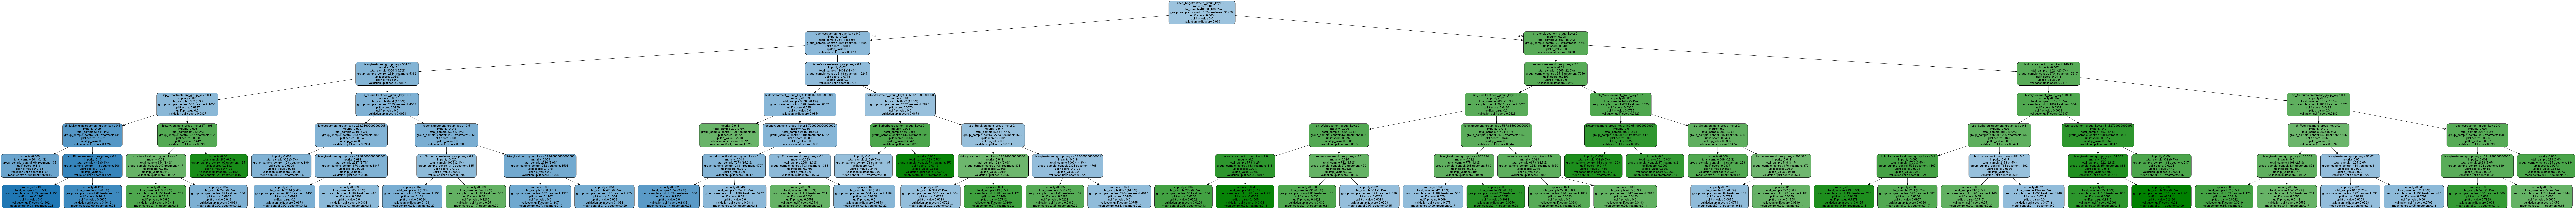

In [66]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=7, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train.values,
                 treatment=treat_train.map({1: 'treatment', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)

Image(graph.create_png())

К примеру я бы использовал дынный лист:\
total sample 231\
control 75 treatment 156\
uplift 0.1962\
p_value 0.0\
mean control 0.03, treatment 0.25\
Здесь 25% людей с кем была коммуникация приняли предложение. Одновременно маленькая группа людей с которыми не было коммуникации и у них низкий таргет, то есть есть шанс, что и там будут люди из группы persuadables.

Данный лист:\
total sample 994\
control 330 treatment 664\
uplift 0.0722\
p_value 0.0099\
mean control 0.20, treatment 0.27\
Считаю, что здесь достаточная разница в mean.